# NEURONSKE MREŽE: PREPOZNAVANJE NOVČANICA

Dodajemo potrebne biblioteke:

In [ ]:
import os
import random
import warnings

import numpy as np
import matplotlib.cbook
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from statistics import mean

from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

Biblioteka za lijep grafički prikaz konfuzijskih matrica:

In [ ]:
# https://github.com/wcipriano/pretty-print-confusion-matrix
#
# kod je modificiran kako bi spremao plt.figure objekt prije plotanja
#

import pretty_confusion_matrix.pretty_confusion_matrix as pcm

Definiranje klasa neuronske mreže i putanja korštenih fotografija:

In [ ]:
train_dir = "Training/"
test_dir = "Testing/"
classes = [
    1,
    2,
    5,
    10,
    20,
    50,
    100,
    500,
    1000,
]

train_folder_paths = ["".join((train_dir, str(note_class))) for note_class in classes]
test_folder_paths = ["".join((test_dir, str(note_class))) for note_class in classes]

Učitavanje fotografija:

In [ ]:
def load_data(train_folder_paths):
    x = []
    y = []
    for folder_path in train_folder_paths:
        for image_file in os.listdir(folder_path):
            image_data = np.array(Image.open(folder_path + "/" + image_file))
            x.append(image_data)
            y.append(folder_path.split("/")[1])
    return x, y

Skaliranje svih fotografija pomoću funkcije preprocessing.scale:

In [ ]:
def standardize_data(image_data):
    image_data = preprocessing.scale(image_data)
    return image_data

Transformacija fotografija tako da su dimenzije jedan:

In [ ]:
x, y = load_data(train_folder_paths)
x_test, y_test = load_data(test_folder_paths)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

for i in range(len(x)):
    x[i] = x[i].reshape(-1)
for i in range(len(x_train)):
    x_train[i] = x_train[i].reshape(-1)
for i in range(len(x_val)):
    x_val[i] = x_val[i].reshape(-1)
for i in range(len(x_test)):
    x_test[i] = x_test[i].reshape(-1)

x = standardize_data(x)
x_train = standardize_data(x_train)
x_val = standardize_data(x_val)
x_test = standardize_data(x_test)

x = np.array(x)
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y = np.array(y)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Funkcija koja računa uspješnost, koja je srednja vrijednost točnosti po svim klasama:

In [ ]:
def mean_class_accuracy_score(true_list, predicted_list):
    assert len(predicted_list) == len(true_list)
    assert len(true_list) != 0
    accuracy_list = []
    for class_label in classes:
        accuracy_list.append(accuracy_score(true_list, predicted_list))
    return mean(accuracy_list)

Funkcija koja iscrtava konfuzijsku matricu:

In [ ]:
def plot_cm(y_test, y_pred, savefig=None):
    warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
    cm = confusion_matrix(y_test, y_pred, labels=["1","2","5","10","20","50","100","500","1000"])
    df_cm = pd.DataFrame(cm, index=[1,2,5,10,20,50,100,500,1000], columns=[1,2,5,10,20,50,100,500,1000])
    pcm.pp_matrix(df_cm, savefig_name=savefig)

# Podaci

Prikaz fotografija novčanica svake vrste:

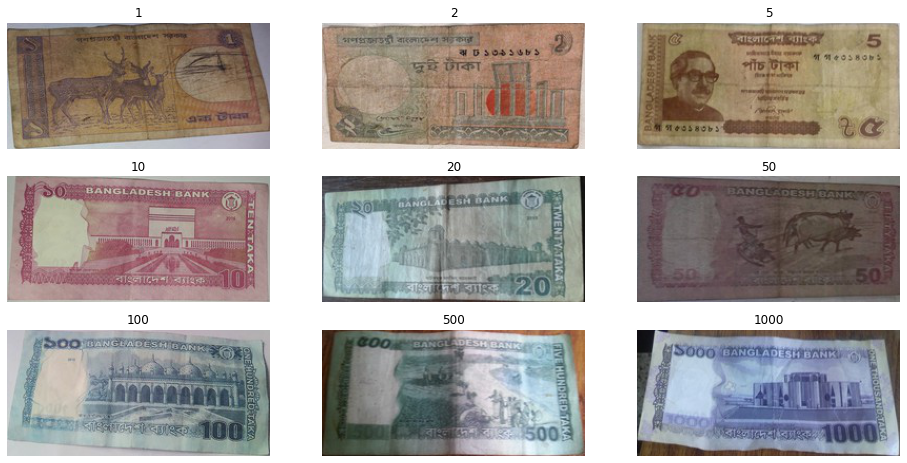

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))
axes = axes.ravel()

assert len(train_folder_paths) == len(axes)

i = 0
for train_path in train_folder_paths:
    image_files = [image for image in os.listdir(train_path) if image.endswith(".jpg")]
    random_file = random.choice(image_files)
    
    file_path = os.path.join(train_path, random_file)
    
    image = Image.open(file_path)
    axes[i].imshow(image)
    axes[i].set_title(train_path.split("/")[1])
    axes[i].axis("off")    
    i += 1

Prikaz broja novčanica za treniranje svake vrste:

In [ ]:
for train_path in train_folder_paths:
    image_files = [image for image in os.listdir(train_path) if image.endswith(".jpg")]
    print(f"Training data length for class {train_path.split('/')[1]}: {len(image_files)}")

Training data length for class 1: 101
Training data length for class 2: 213
Training data length for class 5: 213
Training data length for class 10: 213
Training data length for class 20: 173
Training data length for class 50: 213
Training data length for class 100: 208
Training data length for class 500: 136
Training data length for class 1000: 167


rikaz broja novčanica za testiranje svake vrste:

In [ ]:
for test_path in test_folder_paths:
    image_files = [image for image in os.listdir(test_path) if image.endswith(".jpg")]
    print(f"Test data length for class {test_path.split('/')[1]}: {len(image_files)}")

Test data length for class 1: 20
Test data length for class 2: 37
Test data length for class 5: 37
Test data length for class 10: 38
Test data length for class 20: 37
Test data length for class 50: 37
Test data length for class 100: 37
Test data length for class 500: 37
Test data length for class 1000: 53


In [ ]:
image_files = [image for image in os.listdir(train_folder_paths[0]) if image.endswith(".jpg")]
file_path = os.path.join(train_path, image_files[0])
image = Image.open(file_path)
print(f"Image file shape: {image.size}")

Image file shape: (250, 120)


# Konvolucijska neuronska mreža

Globalne varijable:

In [ ]:
batch_size = 16
image_size = (250, 120)
checkpoint_filepath = 'best_model.h5'

Data preprocess:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

Found 1314 images belonging to 9 classes.


In [ ]:
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 323 images belonging to 9 classes.


Definicija modela neuronske mreže:

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=(image_size[0], image_size[1], 3)),
    keras.layers.Conv2D(32, 3, activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(train_generator.class_indices), activation="softmax")
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 248, 118, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 124, 59, 32)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 122, 57, 64)       18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 61, 28, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 59, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 29, 13, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 48256)            

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

Koristi se optimizator Adam i funkcija gubitka Categorical Cross Entropy:

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Proces treniranja neuronske mreže:

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
83/83 [==============================] - 3s 25ms/step - loss: 2.1870 - accuracy: 0.1446 - val_loss: 2.1688 - val_accuracy: 0.1579

Epoch 00001: val_loss improved from inf to 2.16882, saving model to best_model.h5
Epoch 2/100
83/83 [==============================] - 2s 23ms/step - loss: 1.9906 - accuracy: 0.2496 - val_loss: 1.4299 - val_accuracy: 0.4985

Epoch 00002: val_loss improved from 2.16882 to 1.42990, saving model to best_model.h5
Epoch 3/100
83/83 [==============================] - 2s 23ms/step - loss: 1.1559 - accuracy: 0.5982 - val_loss: 1.0024 - val_accuracy: 0.6718

Epoch 00003: val_loss improved from 1.42990 to 1.00243, saving model to best_model.h5
Epoch 4/100
83/83 [==============================] - 2s 23ms/step - loss: 0.6413 - accuracy: 0.7907 - val_loss: 0.6968 - val_accuracy: 0.8142

Epoch 00004: val_loss improved from 1.00243 to 0.69681, saving model to best_model.h5
Epoch 5/100
83/83 [==============================] - 2s 23ms/step - loss: 0.4038 - accur


Epoch 00040: val_loss did not improve from 0.11029
Epoch 41/100
83/83 [==============================] - 2s 29ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.1315 - val_accuracy: 0.9659

Epoch 00041: val_loss did not improve from 0.11029
Epoch 42/100
83/83 [==============================] - 2s 26ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.1316 - val_accuracy: 0.9690

Epoch 00042: val_loss did not improve from 0.11029
Epoch 43/100
83/83 [==============================] - 2s 26ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.1539 - val_accuracy: 0.9659

Epoch 00043: val_loss did not improve from 0.11029
Epoch 44/100
83/83 [==============================] - 2s 27ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1431 - val_accuracy: 0.9721

Epoch 00044: val_loss did not improve from 0.11029
Epoch 45/100
83/83 [==============================] - 2s 26ms/step - loss: 7.2273e-04 - accuracy: 1.0000 - val_loss: 0.1468 - val_accuracy: 0.9721

Epoch 00045: val_los

83/83 [==============================] - 2s 27ms/step - loss: 1.4939e-04 - accuracy: 1.0000 - val_loss: 0.1413 - val_accuracy: 0.9690

Epoch 00082: val_loss did not improve from 0.05090
Epoch 83/100
83/83 [==============================] - 2s 28ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.1939 - val_accuracy: 0.9598

Epoch 00083: val_loss did not improve from 0.05090
Epoch 84/100
83/83 [==============================] - 2s 28ms/step - loss: 0.2257 - accuracy: 0.9323 - val_loss: 0.3440 - val_accuracy: 0.9288

Epoch 00084: val_loss did not improve from 0.05090
Epoch 85/100
83/83 [==============================] - 2s 28ms/step - loss: 0.1091 - accuracy: 0.9749 - val_loss: 0.4184 - val_accuracy: 0.9009

Epoch 00085: val_loss did not improve from 0.05090
Epoch 86/100
83/83 [==============================] - 2s 30ms/step - loss: 0.1700 - accuracy: 0.9543 - val_loss: 0.2912 - val_accuracy: 0.9226

Epoch 00086: val_loss did not improve from 0.05090
Epoch 87/100
83/83 [==============

Proces testiranja neuronske mreže:

In [ ]:
def custom_evaluation(y_true, y_pred):
    converted_y_pred = []
    for model_output in y_pred:
        converted_y_pred.append(np.argmax(model_output))
    return mean_class_accuracy_score(y_true, converted_y_pred)

In [ ]:
model = load_model(checkpoint_filepath)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 333 images belonging to 9 classes.


In [ ]:
y_pred = model.predict_generator(test_generator)
y_true = test_generator.classes
assert len(y_true) == len(y_pred)

Izračun točnosti neuronske mreže:

In [ ]:
accuracy = custom_evaluation(y_true, y_pred)
print(f"Model accuracy evaluated by custom_accuracy function: {accuracy}")

Model accuracy evaluated by custom_accuracy function: 0.9819819819819819


In [ ]:
pred_results = []
for prediction in y_pred:
    pred_results.append(np.argmax(prediction))

In [ ]:
converted_y_test = \
[
    '1' if y == 0 else
    '10' if y == 1 else
    '100' if y == 2 else 
    '1000' if y == 3 else
    '2' if y == 4 else 
    '20' if y == 5 else
    '5' if y == 6 else
    '50' if y == 7 else
    '500' for
    y in y_true
]
converted_y_test = np.array(converted_y_test).reshape(-1)

In [ ]:
converted_y_pred = \
[
    '1' if y == 0 else
    '10' if y == 1 else
    '100' if y == 2 else 
    '1000' if y == 3 else
    '2' if y == 4 else 
    '20' if y == 5 else
    '5' if y == 6 else
    '50' if y == 7 else
    '500' for
    y in pred_results
]
converted_y_pred = np.array(converted_y_pred).reshape(-1)

Prikaz konfuzijske matrice za implementiranu konvolucijsku neuronsku mrežu:

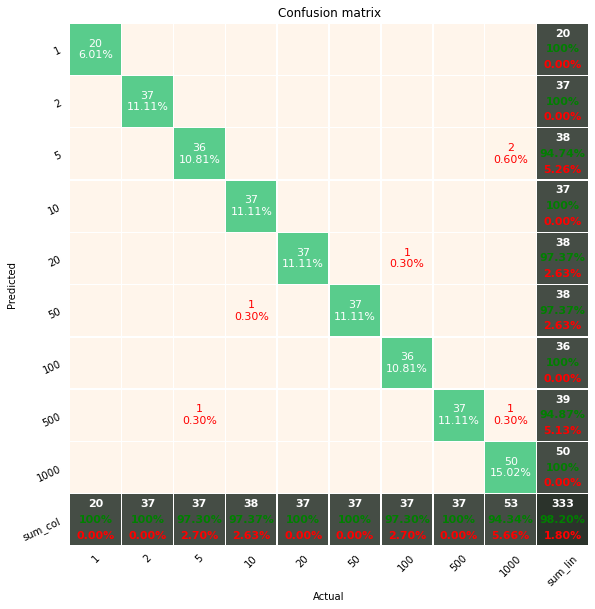

In [ ]:
plot_cm(converted_y_test, converted_y_pred, savefig=f"cnn_convolution_matrix_results.png")

# Implementacija k-nn klasifikacije

https://scikit-learn.org/stable/modules/neighbors.html#classification

Definicija modela:

In [ ]:
def get_knn_model(n_neighbors, x_train, y_train):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_train, y_train)
    return knn

Funkcija koja provodi k-nn klasifikaciju za parametre k = 3, 5, 7, 9, 13 te vraća onaj k za koji je točnost najveća:

In [ ]:
def get_best_num_neighbors(x_train, 
                           y_train, 
                           x_val, 
                           y_val, 
                           neighbors_list=[3,5,7,9,13], 
                           verbose=True):
    best_num, best_acc = 0, 0
    for num_neighbors in neighbors_list:
        knn = get_knn_model(num_neighbors, x_train, y_train)
        y_pred = knn.predict(x_val)
        model_accuracy = mean_class_accuracy_score(y_val, y_pred)
        if verbose is True:
            print(f"K-nn accuracy: {model_accuracy*100:.2f} for num_neighbors = {num_neighbors}")
        if best_acc < model_accuracy:
            best_num, best_acc = num_neighbors, model_accuracy
    return best_num

Izvođenje prethodne funkcije:

In [ ]:
best_num = get_best_num_neighbors(x_train, y_train, x_val, y_val)

K-nn accuracy: 80.18 for num_neighbors = 3
K-nn accuracy: 79.88 for num_neighbors = 5
K-nn accuracy: 79.27 for num_neighbors = 7
K-nn accuracy: 79.57 for num_neighbors = 9
K-nn accuracy: 76.22 for num_neighbors = 13


Ispis najboljeg parametra k (u ovom slučaju je to k = 3):

In [ ]:
knn_whole_data = get_knn_model(best_num, x, y)
y_pred = knn_whole_data.predict(x_test)
model_accuracy = mean_class_accuracy_score(y_test, y_pred)
print(f"On whole data, K-nn accuracy: {model_accuracy*100:.2f} for num_neighbors = {best_num}")

On whole data, K-nn accuracy: 68.47 for num_neighbors = 3


In [ ]:
#K-nn accuracy: 80.18 for num_neighbors = 3  
#K-nn accuracy: 79.88 for num_neighbors = 5  
#K-nn accuracy: 79.27 for num_neighbors = 7  
#K-nn accuracy: 79.57 for num_neighbors = 9  
#K-nn accuracy: 76.22 for num_neighbors = 13  
#On whole data, K-nn accuracy: 68.47 for num_neighbors = 3

Prikaz konfuzijske matrice za k-nn s parametrom k = 3:

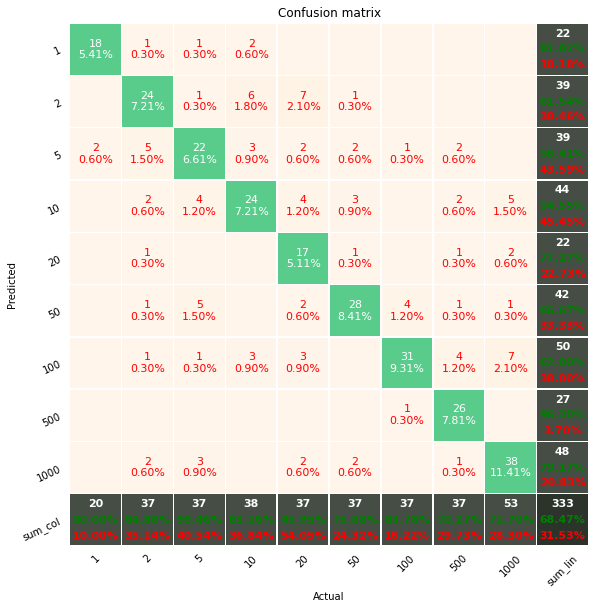

In [ ]:
plot_cm(y_test, y_pred, savefig=f"knn_num_{str(best_num)}.png")

# Implementacija SVC klasifikacije

https://scikit-learn.org/stable/modules/svm.html#svm-classification

Kreiranje modela:

In [ ]:
def get_svc_model(kernel, x_train, y_train):
    svc = svm.SVC(kernel=kernel)
    svc.fit(x_train, y_train)
    return svc

Funkcija koja provodi SVC klasifikaciju s jezgrama 'linear', 'poly', 'rbf', 'sigmoid' te vraća onu jezgru za koji je točnost najveća:

In [ ]:
def get_best_kernel(x_train,
                    y_train,
                    x_val,
                    y_val,
                    kernels=['linear', 'poly', 'rbf', 'sigmoid'],
                    verbose=True):
    best_acc = 0
    best_kernel = None
    for kernel in kernels:
        svc_clf = get_svc_model(kernel, x_train, y_train)
        y_pred = svc_clf.predict(x_val)

        accuracy = mean_class_accuracy_score(y_val, y_pred)
        if verbose is True:
            print(f"Accuracy for kernel = {kernel}: {accuracy}")

        if accuracy > best_acc:
            best_acc = accuracy
            best_kernel = kernel
    return best_kernel

Izvođenje prethodne funkcije:

In [ ]:
best_kernel = get_best_kernel(x_train, y_train, x_val, y_val)

Accuracy for kernel = linear: 0.9664634146341463
Accuracy for kernel = poly: 0.6798780487804879
Accuracy for kernel = rbf: 0.948170731707317
Accuracy for kernel = sigmoid: 0.5121951219512195


Ispis najbolje jezgre u SVC modelu klasifikacije (u ovom slučaju je to 'linear'):

In [ ]:
svc_whole_data = get_svc_model(best_kernel, x, y)
y_pred = svc_whole_data.predict(x_test)
model_accuracy = mean_class_accuracy_score(y_test, y_pred)
print(f"On whole data, K-nn accuracy: {model_accuracy*100:.2f} for kernel = {best_kernel}")

On whole data, K-nn accuracy: 96.40 for kernel = linear


In [ ]:
#Accuracy for kernel = linear: 0.9664634146341463
#Accuracy for kernel = poly: 0.6798780487804879
#Accuracy for kernel = rbf: 0.948170731707317
#Accuracy for kernel = sigmoid: 0.5121951219512195
#On whole data, K-nn accuracy: 96.40 for kernel = linear

Prikaz konfuzijske matrice za SVC klasifikator s jezgrom 'linear':

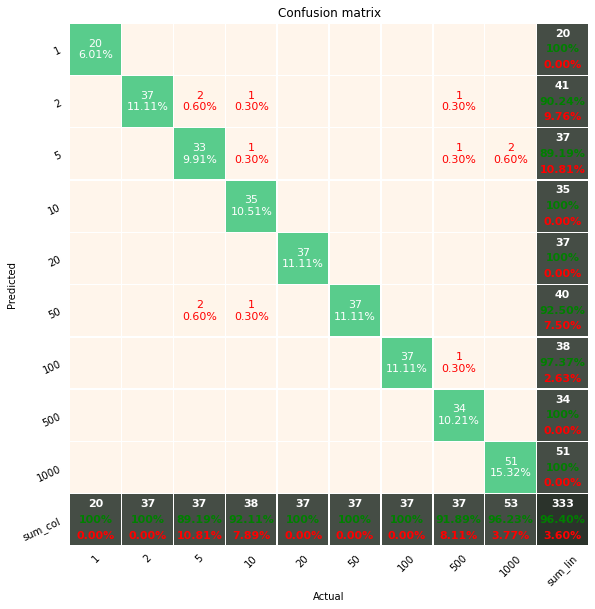

In [ ]:
plot_cm(y_test, y_pred, savefig=f"svm_svc_kernel={best_kernel}.png")